# Analysis of an optimal solution

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import glob
import networkx

mpl.rc('text', usetex=True)
mpl.rc('font', size=16)
mpl.rc('legend', fontsize=14)

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

when = 'future-mobintime'
file_prefix = f'week'

nnodes = 107  # nodes
ndays = 90

setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Provincial Setup with 107 nodes.


In [2]:
files_n = {'Optimistic':  'model_output/2021-02-19/L-r15-t479700-id7-opi-107_90.csv',
           'Pessimistic': 'model_output/2021-02-19/U-r15-t479700-id6-opi-107_90.csv'}
files_n = {'Optimistic':  'helvetios-runs/2021-11-17-107_90/week-L-r15-t479700-id7-opt-107_90.csv',
           'Pessimistic': 'helvetios-runs/2021-11-17-107_90/week-U-r15-t479700-id6-opt-107_90.csv'}

In [7]:
#dates_interm = pd.date_range(setup.start_date, setup.end_date, freq='30D')
#dates_interm

In [3]:
(p.x0.sum(axis=1)/setup.pop_node).min()*100

99.14964815647082

'L'

In [24]:
fn

'helvetios-runs/2021-11-17-107_90/week-L-r15-t479700-id6-int-107_90.csv'

In [7]:
results = {}

methods = ['opi', 'pinc', 'ppop', 'psus']
methods = ['opi', 'finc', 'pinc', 'fsus', 'psus','fincpp', 'pincpp', 'fsuspp', 'psuspp', 'ppop', 'fpop']
methods = ['opt']
for scn, fn in files_n.items():
    results[scn] = {}
    # Find baseline:
    scn_letter = fn.split('-')[-6]
    baseline_fn = glob.glob(f'helvetios-runs/2021-11-17-107_90/week-{scn_letter}*nc.csv')[0]
    bl = pd.read_csv(baseline_fn, index_col= 'date', parse_dates=True)
    for met in methods: 
        md = pd.read_csv(fn.replace('opt', met), index_col= 'date', parse_dates=True)

        res = setup.shp.copy()
        res['vacc'] = np.nan
        res['Send'] = np.nan
        for i, node in enumerate(setup.ind2name):

            mdp = md[md['place']==node]
            blp = bl[bl['place']==node]

            total_vacc = mdp[ mdp['comp']=='vacc']['value'].sum()
            Send       = mdp[ mdp['comp']=='S']['value'][-1]
            Sstart     = mdp[ mdp['comp']=='S']['value'][0]
            ndays_vacc = len(mdp[(mdp['comp']=='vacc') & (mdp['value']>1)])
            total_inf  = mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (mdp.index == str(setup.end_date))]['value'].sum()
            new_inf    = mdp[ mdp['comp']=='yell']['value'].sum() # mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A']) & (mdp.index == str(setup.end_date))]['value'].sum()
            new_inf_bl = blp[ blp['comp']=='yell']['value'].sum()

            res.loc[i, 'total_vacc'] = total_vacc
            res.loc[i, 'total_vacc_pop'] = total_vacc/setup.pop_node[i]
            res.loc[i, 'Send'] =       Send
            res.loc[i, 'Sstart'] =       Sstart
            res.loc[i, 'ndays_vacc'] = ndays_vacc
            res.loc[i, 'total_inf'] =  total_inf
            res.loc[i, 'new_inf'] =    new_inf
            res.loc[i, 'new_inf_pop'] =    new_inf/setup.pop_node[i]
            res.loc[i, 'new_inf_bl'] =    new_inf_bl
            res.loc[i, 'averted'] = new_inf_bl - new_inf
            res.loc[i, 'averted_pop'] = (new_inf_bl - new_inf)/setup.pop_node[i]
            res.loc[i, 'averted_infbl'] = (new_inf_bl - new_inf)/new_inf_bl
            res.loc[i, 'Send_pop'] = Send/setup.pop_node[i]
            res.loc[i, 'Sstart_pop'] = Sstart/setup.pop_node[i]
            res.loc[i, 'population'] = setup.pop_node[i] # overwrite 

            #for dt in dates_interm:
            #    res.loc[i, f'total_vacc{str(dt.date())}'] = mdp[(mdp['comp']=='vacc') & (mdp.index < dt)]['value'].sum()
        results[scn][met] = res

In [8]:
for scn, fn in files_n.items():
    results[scn]['Optimal'] = results[scn].pop('opt')

In [ ]:
for scn, fn in files_n.items():
    results[scn]['Optimal'] = results[scn].pop('opt')
    results[scn]['Population'] = results[scn].pop('ppop')
    results[scn]['Incidence'] = results[scn].pop('pinc')
    results[scn]['Susceptibility'] = results[scn].pop('psus')

    results[scn]['Focused Incidence'] = results[scn].pop('finc')
    results[scn]['Focused Population'] = results[scn].pop('fpop')
    results[scn]['Focused Susceptibility'] = results[scn].pop('fsus')

    results[scn]['Focused Proportional Incidence'] = results[scn].pop('fincpp')
    results[scn]['Focused Proportional Susceptibility'] = results[scn].pop('fsuspp')

    results[scn]['Proportional Incidence'] = results[scn].pop('pincpp')
    results[scn]['Proportional Susceptibility'] = results[scn].pop('psuspp')

<AxesSubplot:>

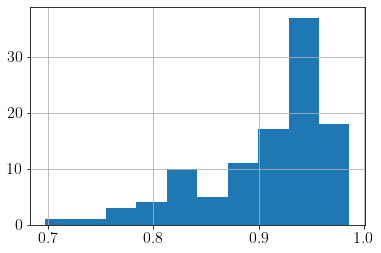

In [36]:
(results['Optimistic']['Optimal']['Sstart']/results['Optimistic']['Optimal']['population']).hist()

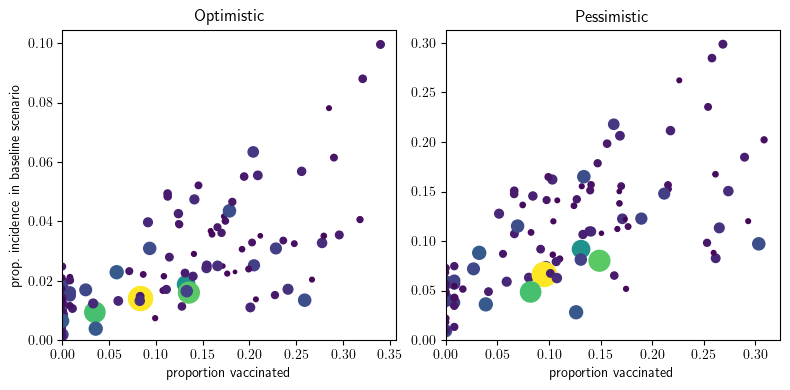

In [9]:
fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 100)


for i, (scn_name, res) in enumerate(results.items()):
    res = res['Optimal']
    
    ax = axes[i]
    ax.scatter(res['total_vacc']/res['population'], 
               res['new_inf_bl']/res['population'], 
               s=res.population/max(res.population)*300, 
               c=res.population/max(res.population)*300, cmap='viridis')

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    #ax.set_xlabel('prop. optimal vaccine coverage')
    if i == 0: 
        ax.set_ylabel('prop. incidence in baseline scenario')
    ax.set_title(f'{scn_name}')
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.grid()
    ax.set_xlabel('proportion vaccinated')
fig.tight_layout()
fig.savefig('figures/scatter_top.pdf')

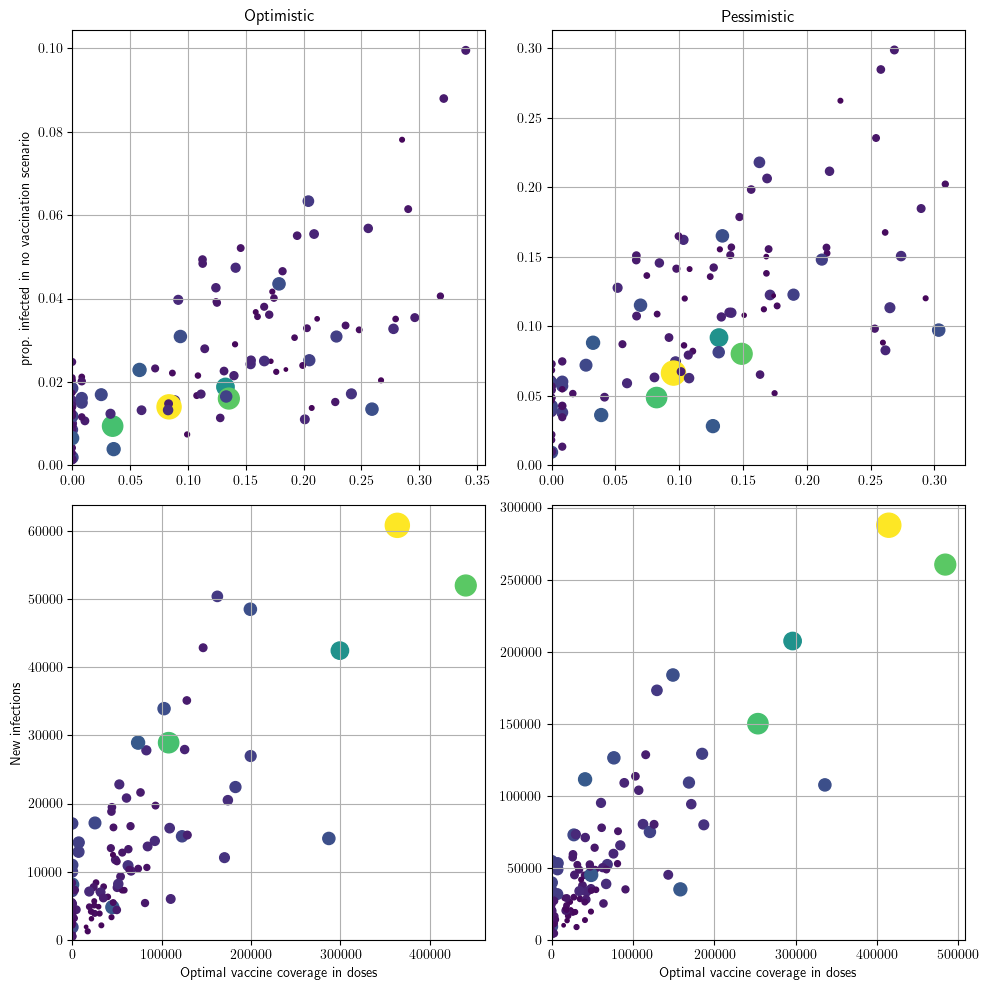

In [10]:
fig, axes = plt.subplots(2,2, figsize=(10,10), dpi = 100)


for i, (scn_name, res) in enumerate(results.items()):
    res = res['Optimal']
    
    ax = axes[0,i]
    ax.scatter(res['total_vacc']/res['population'], 
               res['new_inf_bl']/res['population'], 
               s=res.population/max(res.population)*300, 
               c=res.population/max(res.population)*300)

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    #ax.set_xlabel('prop. optimal vaccine coverage')
    if i == 0: 
        ax.set_ylabel('prop. infected in no vaccination scenario')
    ax.set_title(f'{scn_name}')
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    ax = axes[1,i]
    ax.scatter(res['total_vacc'], 
           res['new_inf_bl'], 
           s=res.population/max(res.population)*300, 
           c=res.population/max(res.population)*300)

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    ax.set_xlabel('Optimal vaccine coverage in doses')
    if i == 0:
        ax.set_ylabel('New infections')
    #ax.set_title(f'{scn_name}')
    ax.set_xlim(0)
    ax.set_ylim(0)
fig.tight_layout()
fig.savefig('figures/scatter_all.pdf')

In [ ]:
Total # of vaccines, Total averted cases, **%** Susceptible left at the end.

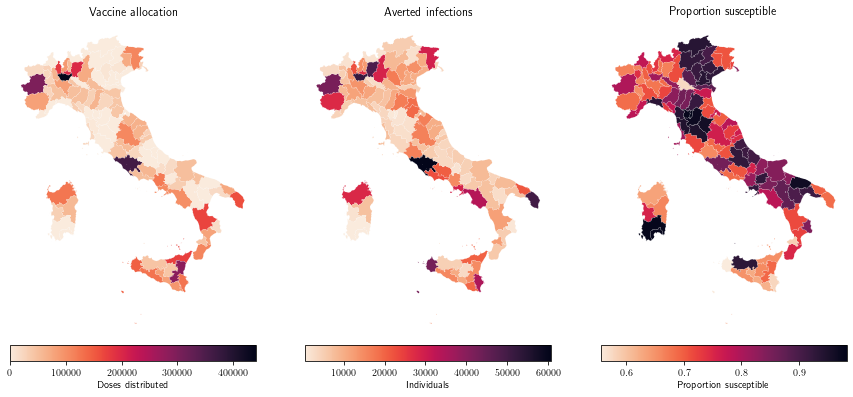

In [11]:
fig, axes = plt.subplots(1,3, figsize=(15, 10))
from mpl_toolkits.axes_grid1 import make_axes_locatable
res = results['Optimistic']['Optimal']

plt_infos = {'total_vacc': 
             {'legend':'Doses distributed',
              'title': 'Vaccine allocation'},
            'averted': 
             {'legend':'Individuals',
              'title': 'Averted infections'},
            'Send_pop': 
             {'legend':'Proportion susceptible',
              'title': 'Proportion susceptible'}}


for i, (colname, details) in enumerate(plt_infos.items()):
    ax=axes.flat[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    mp = res.plot(ax = ax, column=colname, cmap='rocket_r', lw = .1, edgecolor="white", cax = cax, legend=True, legend_kwds={'label': details['legend'],     'orientation': "horizontal"})
    ax.set_title(details['title'])
    ax.axis('off')
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)

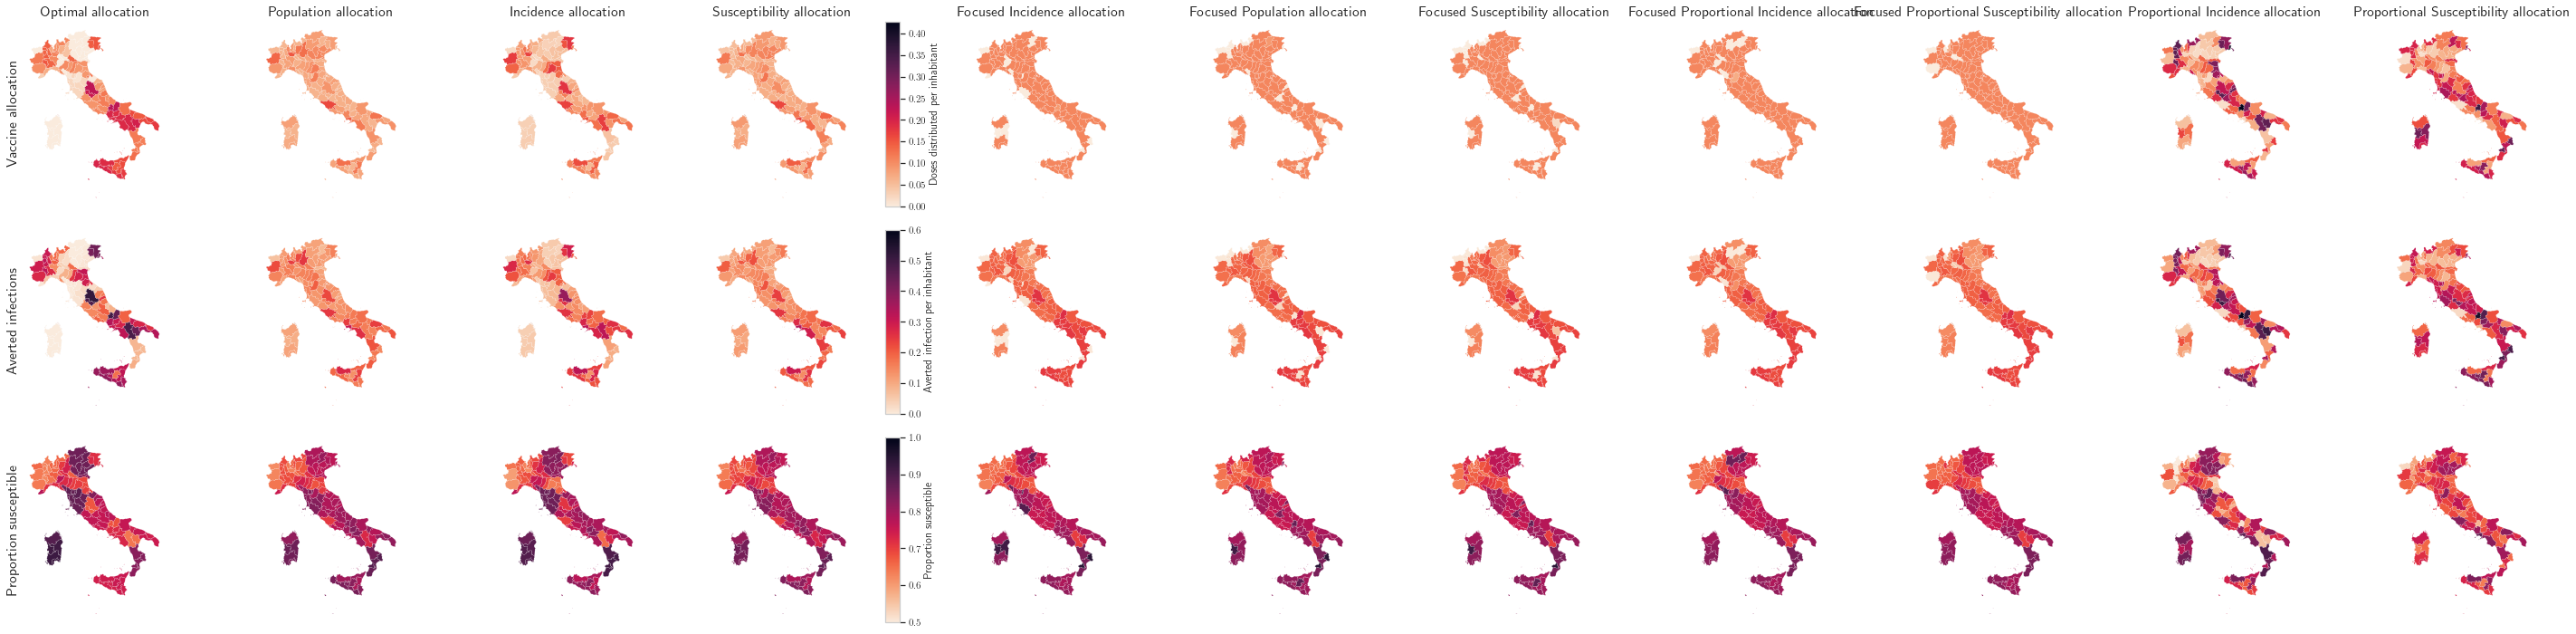

In [21]:
fig, axes_all = plt.subplots(3,4, figsize=(15, 10))
from mpl_toolkits.axes_grid1 import make_axes_locatable
res = results['Pessimistic']

plt_infos = {'total_vacc_pop': 
             {'legend':'Doses distributed per inhabitant',
              'title': 'Vaccine allocation',
               'vmax': max([max(rs['total_vacc_pop']) for met, rs in res.items()]),
               'vmin':0},
            'averted_infbl': 
             {'legend':'Averted infection per inhabitant',
              'title': 'Averted infections',
               'vmax': max([max(rs['averted_infbl']) for met, rs in res.items()]),
               'vmin':0},
            'Send_pop': 
             {'legend':'Proportion susceptible',
              'title': 'Proportion susceptible',
               'vmax': 1 ,
               'vmin':0.5}}


mpl.rc('font', size=16)
mpl.rc('legend', fontsize=14)

for j, (colname, details) in enumerate(plt_infos.items()):
    axes = axes_all[j]
    for i, (met, rs) in  enumerate(res.items()):
        ax=axes.flat[i]
        if i == 3:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="10%", pad=0.5)
            mp = rs.plot(ax = ax, column=colname, 
                         cmap='rocket_r', 
                         lw = .1, 
                         edgecolor="white", 
                         vmin = details['vmin'],
                         vmax = details['vmax'],
                         cax = cax, 
                         legend=True, 
                         legend_kwds={'label': details['legend'],   'orientation': "vertical"})
            
            #cax.tick_params(labelsize=14)

        else:
            #divider = make_axes_locatable(ax)
            #cax2 = divider.append_axes("bottom", size="5%", pad=0.1)
            mp = rs.plot(ax = ax, column=colname, 
                         cmap='rocket_r', 
                         lw = .1, 
                         edgecolor="white", 
                         vmin = details['vmin'],
                         vmax = details['vmax'])
        if j == 0: ax.set_title(f'{met} allocation', fontsize=16)
        #ax.axis('off')
        if i == 0: ax.set_ylabel(details['title'], fontsize=16)
            
        ax.set_yticklabels([], fontsize=14)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

fig.tight_layout()
fig.savefig('figures/map_all.pdf')

In [12]:
fig, ax = plt.subplots(1, len(dates_interm),figsize=(10, 30), dpi = 200)

cmap = mpl.cm.OrRd #viridis  #sns.cm.rocket  'OrRd'
vmin = 0
vmax = 2.5e5#max(setup.shp.total_vacc)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cmap = fig.colorbar(sm, ax=ax.ravel().tolist(), shrink=.04, ticks=np.arange(0, vmax, vmax/5))
cmap.ax.set_title('Doses', fontsize=6)

for i, dt in enumerate(dates_interm):
    setup.shp.plot(ax = ax.flat[i], column=f'total_vacc{str(dt.date())}', 
                          edgecolor="black", lw = .1, cmap = 'OrRd', vmin=vmin, vmax=vmax)
    #facecolor="none",
    ax.flat[i].axis('off')
    ax.flat[i].set_title(str(dt.date()), fontsize = 8)
#fig.subplots_adjust(right=0.8)
# put colorbar at desire position
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(ax.flat[i])
cmap.ax.set_yticklabels(['{:.1e}'.format(x) for x in np.arange(0, vmax,vmax/5)], fontsize=6);#, weight='bold')
fig.savefig('figures/map_tf.pdf')

NameError: name 'dates_interm' is not defined

In [26]:
G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node[i]


    for j, connection in enumerate(p.mobmat[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection, color='grey')
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection*200, color = 'r')  # TODO: add min


G.number_of_edges()

2360

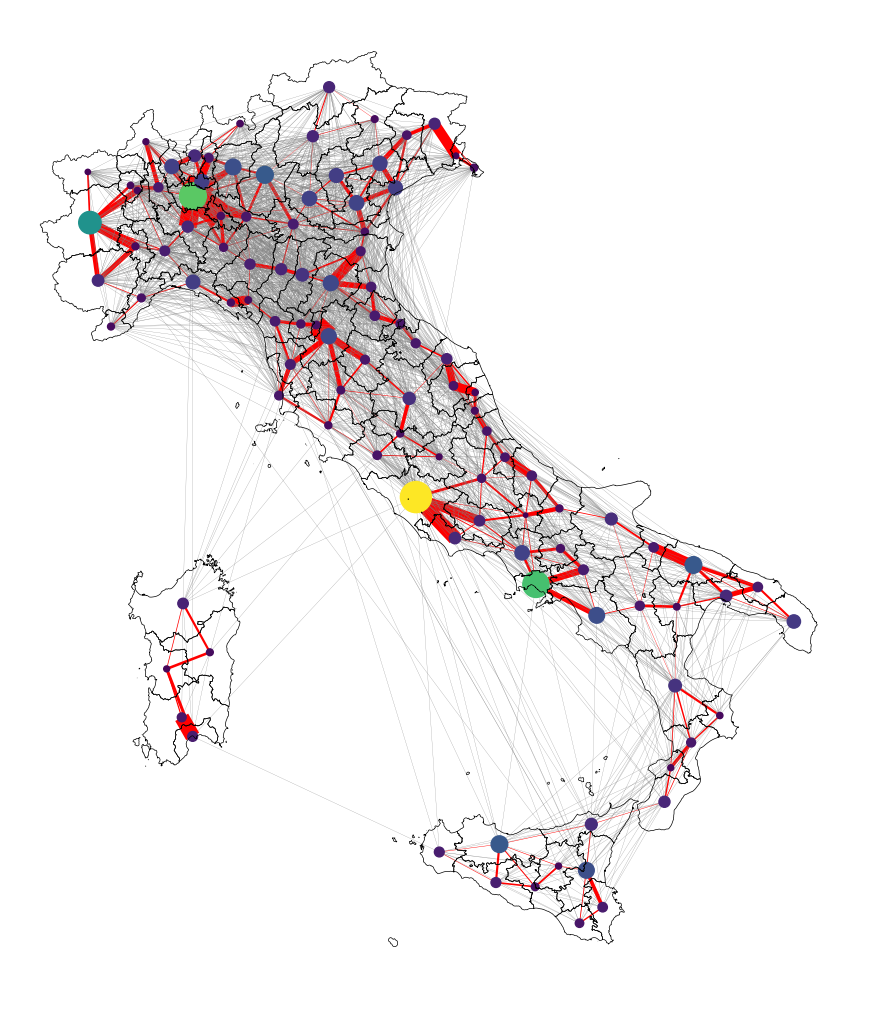

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi=100, constrained_layout=True) #

networkx.draw(G, 
          G.position, 
          node_size=500/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          node_color=[G.population[v] for v in G],
          width = 40* np.array([max(a['weight']/100,0.004) for u,v,a in G.edges(data=True)]),
         # edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
         edge_color= [a['color'] for u,v,a in G.edges(data=True)],
          edge_cmap = mpl.cm.viridis,
          cmap = mpl.cm.viridis,
          ax = ax,
         #with_labels=True
       )

#     # scale the axes equally
plt.xlim(min(setup.pos_node[:,0]) - 100000, max(setup.pos_node[:,0])+ 100000)
plt.ylim(min(setup.pos_node[:,1]) - 100000, max(setup.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="k", linewidth = .5)


#cmap = mpl.cm.viridis#sns.cm.rocket
#vmin = min([G.epi[v]['total_vacc']/G.population[v] for v in G])
#vmax = max([G.epi[v]['total_vacc']/G.population[v] for v in G])
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
##sm._A = []
#cmap = fig.colorbar(sm, ax=ax, shrink=.3,  ticks=np.arange(0, vmax, vmax/10),location = 'right')

#cmap.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(0, vmax,vmax/10)], fontsize=16)#, weight='bold')

plt.draw()
fig.savefig('figures/map_nd.pdf')
fig.savefig('figures/map_nd.png')

In [15]:
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(16)}
scenarios.keys()
# Choose a subset of scenarios:
pick = 'r15-'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}
print(len(scenarios))

12


In [63]:
scenarios = {k:v for (k,v) in scenarios.items() if 't125000' not in k}
scenarios = {k:v for (k,v) in scenarios.items() if 't250000' not in k}

In [64]:
scenarios.keys()

dict_keys(['U-r15-t479700-id6', 'L-r15-t479700-id7', 'U-r15-t1000000-id8', 'L-r15-t1000000-id9', 'U-r15-t1500000-id10', 'L-r15-t1500000-id11', 'U-r15-t2000000-id12', 'L-r15-t2000000-id13'])

In [19]:
generated_dir = 'helvetios-runs/2021-11-17-107_90'
met = 'opt'
import os
results_s = {}
for scn, fn in files_n.items():
    results_s[scn] = {}
    # Find baseline:
    scn_letter = fn.split('-')[-6]
    baseline_fn = glob.glob(f'helvetios-runs/2021-11-17-107_90/week-{scn_letter}*nc.csv')[0]
    bl = pd.read_csv(baseline_fn, index_col= 'date', parse_dates=True)

    for scenario_name, scenario in scenarios.items():
        filename = f'{generated_dir}/week-{scenario_name}-{met}-{nnodes}_{ndays}.csv'
        if os.path.isfile(filename) and scenario_name.split('-')[0] == scn_letter:
            print(f'Doing {filename} for {scn}')
            maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)

            md = pd.read_csv(filename, index_col= 'date', parse_dates=True)
            res = setup.shp.copy()

            for i, node in enumerate(setup.ind2name):

                mdp = md[md['place']==node]
                blp = bl[bl['place']==node]

                total_vacc = mdp[ mdp['comp']=='vacc']['value'].sum()
                new_inf_bl = blp[ blp['comp']=='yell']['value'].sum()

                res.loc[i, 'total_vacc'] = total_vacc
                res.loc[i, 'total_vacc_pop'] = total_vacc/setup.pop_node[i]
                res.loc[i, 'new_inf_bl'] =    new_inf_bl
                res.loc[i, 'new_inf_bl_pop'] =    new_inf_bl/setup.pop_node[i]
            results_s[scn][scenario_name] = res

Doing helvetios-runs/2021-11-17-107_90/week-L-r15-t125000-id3-opt-107_90.csv for Optimistic
Doing helvetios-runs/2021-11-17-107_90/week-L-r15-t250000-id5-opt-107_90.csv for Optimistic
Doing helvetios-runs/2021-11-17-107_90/week-L-r15-t479700-id7-opt-107_90.csv for Optimistic
Doing helvetios-runs/2021-11-17-107_90/week-L-r15-t1000000-id9-opt-107_90.csv for Optimistic
Doing helvetios-runs/2021-11-17-107_90/week-L-r15-t1500000-id11-opt-107_90.csv for Optimistic
Doing helvetios-runs/2021-11-17-107_90/week-L-r15-t2000000-id13-opt-107_90.csv for Optimistic
Doing helvetios-runs/2021-11-17-107_90/week-U-r15-t125000-id2-opt-107_90.csv for Pessimistic
Doing helvetios-runs/2021-11-17-107_90/week-U-r15-t250000-id4-opt-107_90.csv for Pessimistic
Doing helvetios-runs/2021-11-17-107_90/week-U-r15-t479700-id6-opt-107_90.csv for Pessimistic
Doing helvetios-runs/2021-11-17-107_90/week-U-r15-t1000000-id8-opt-107_90.csv for Pessimistic
Doing helvetios-runs/2021-11-17-107_90/week-U-r15-t1500000-id10-opt-10

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

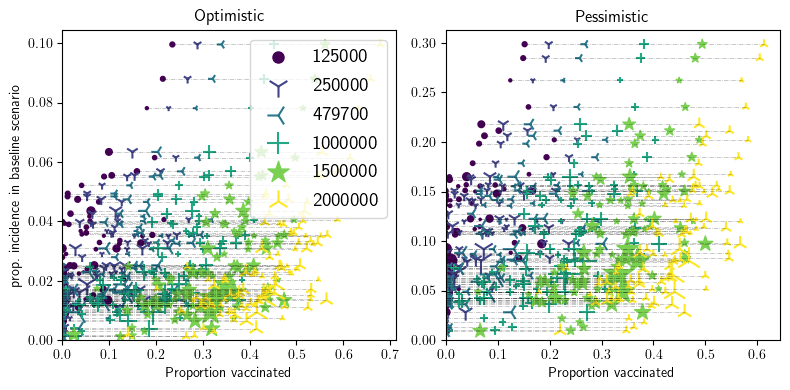

In [29]:
fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 100)

c = ['yellow', 'orange', 'red', 'pink', 'red']

import cycler

m = ['.','1','3','+','*','2']

n = 6
color = plt.cm.viridis(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for i, (scn_name, res_all) in enumerate(results_s.items()):
    ax = axes[i]
    ax.plot([res['total_vacc']/res['population'] for i, (scenario_name, res) in enumerate(res_all.items()) ],  # /res['population']
            [res['new_inf_bl']/res['population'] for i, (scenario_name, res) in enumerate(res_all.items()) ], c = 'k', lw = .5, alpha = .3, ls = '-.')
    for j, (scenario_name, res) in enumerate(res_all.items()):
    
        ax.scatter(res['total_vacc']/res['population'], 
                   res['new_inf_bl']/res['population'], 
                   s=res.population/max(res.population)*500, 
                   c=color[j],
                   label = scenario_name.split('-')[2][1:], alpha = 1, marker = m[j])

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    #ax.set_xlabel('prop. optimal vaccine coverage')
    if i == 0:
        ax.set_ylabel('prop. incidence in baseline scenario')
        ax.legend()
    ax.set_title(f'{scn_name}')
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    ax.set_xlabel('Proportion vaccinated')
    ax.grid()
    
fig.tight_layout()
fig.savefig('figures/scatter_scn.pdf')

In [23]:
color[j]

IndexError: index 5 is out of bounds for axis 0 with size 5

57441.137341576905

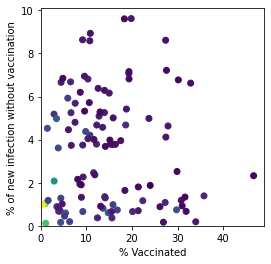

In [18]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['total_vacc']/setup.shp['population']*100, setup.shp['new_inf_bl']/setup.shp['population']*100, c= setup.shp['population'])
ax.set_xlabel("% Vaccinated")
ax.set_ylabel("% of new infection without vaccination");
ax.set_xlim(0)
ax.set_ylim(0)
fig.savefig('figures/scatter_vacc_inf.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


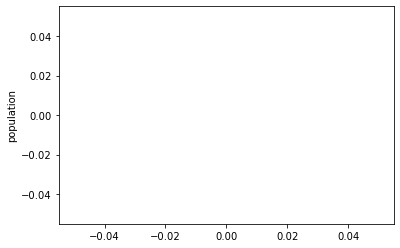

In [17]:
ax = sns.scatterplot(setup.shp['vacc'], setup.shp['population'], hue=setup.shp['Rend'])
ax.get_legend().remove();
#ax.set(xscale="log", yscale="log")

KeyError: 'total_vacc'

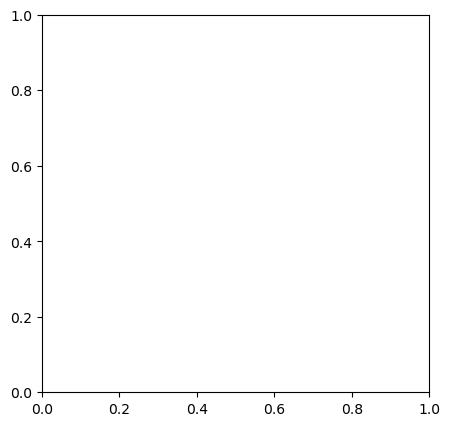

In [19]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['total_vacc'], 
           setup.shp['population'],
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
ax.set_ylabel('Province population (log)')
ax.set_xlabel('Vaccine doses')
ax.set(yscale="log") 
fig.savefig('figures/scatter_vacc_pop.pdf')

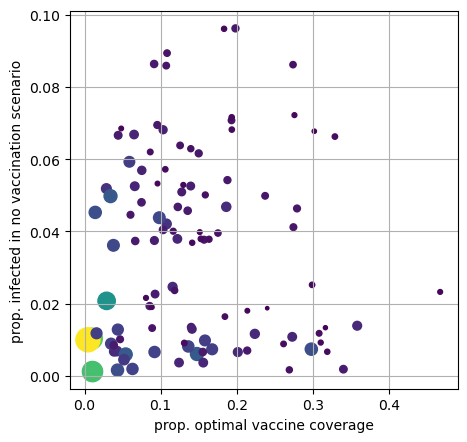

In [15]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['total_vacc']/setup.shp['population'], 
           setup.shp['new_inf_bl']/setup.shp['population'], 
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
#ax.set( yscale="log", xscale="log") #
ax.set_xlabel('prop. optimal vaccine coverage')
ax.set_ylabel('prop. infected in no vaccination scenario')
fig.savefig('figures/scatter_vacc_inf.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


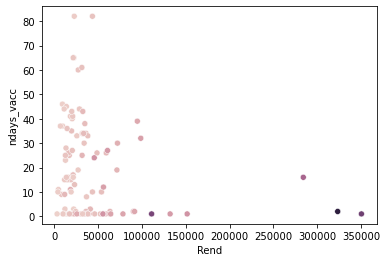

In [196]:
ax = sns.scatterplot(setup.shp['Rend'], setup.shp['ndays_vacc'], hue=setup.shp['population'])
ax.get_legend().remove();

In [202]:
setup.shp.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'DEN_PROV',
       'DEN_CM', 'DEN_UTS', 'SIGLA', 'TIPO_UTS', 'Shape_Leng', 'Shape_Area',
       'geometry', 'name', 'population', 'mobile_fraction', 'vacc', 'Rend',
       'total_vacc', 'ndays_vacc', 'total_inf', 'new_inf', 'new_inf_bl',
       'total_vacc2021-01-01', 'total_vacc2021-01-10', 'total_vacc2021-01-19',
       'total_vacc2021-01-28', 'total_vacc2021-02-06', 'total_vacc2021-02-15',
       'total_vacc2021-02-24', 'total_vacc2021-03-05', 'total_vacc2021-03-14',
       'total_vacc2021-03-23', 'total_vacc2021-01-16', 'total_vacc2021-01-31',
       'total_vacc2021-03-02', 'total_vacc2021-03-17'],
      dtype='object')

In [9]:
df = results['Optimistic']['Optimal']
df = df.sort_values('total_vacc', ascending=False)
df = df[df.columns[13:]]

df

,name,population,mobile_fraction,vacc,Send,total_vacc,total_vacc_pop,Sstart,ndays_vacc,total_inf,new_inf,new_inf_pop,new_inf_bl,averted,averted_pop,averted_infbl,Send_pop
62,Napoli,3084900,0.41702,NaN,2.113604e+06,601881.721666,0.195106,2.862225e+06,24.0,364937.538601,4296.319853,0.001393,7571.670164,3275.350312,0.001062,0.432580,0.685145
57,Roma,4342200,0.50967,NaN,3.104140e+06,388768.485414,0.089533,3.766893e+06,11.0,840295.254424,6874.154239,0.001583,8342.514413,1468.360174,0.000338,0.176009,0.714877
14,Milano,3250300,0.54499,NaN,2.004896e+06,318741.563874,0.098065,2.495628e+06,13.0,915727.761807,5190.322667,0.001597,6660.404289,1470.081621,0.000452,0.220720,0.616834
81,Palermo,1252600,0.41536,NaN,8.760746e+05,237643.669796,0.189720,1.182609e+06,23.0,137296.719922,1828.216833,0.001460,3430.941543,1602.724710,0.001280,0.467138,0.699405
64,Salerno,1098500,0.43282,NaN,7.518409e+05,214513.833627,0.195279,1.019834e+06,24.0,130576.524051,1552.873258,0.001414,2765.661608,1212.788350,0.001104,0.438517,0.684425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Treviso,887810,0.54282,NaN,7.364545e+05,0.000000,0.000000,7.792818e+05,0.0,149679.796937,851.811124,0.000959,863.228667,11.417543,0.000013,0.013227,0.829518
26,Venezia,853340,0.51450,NaN,7.071270e+05,0.000000,0.000000,7.482159e+05,0.0,144774.619307,817.360866,0.000958,834.745940,17.385074,0.000020,0.020827,0.828658
27,Padova,937910,0.54409,NaN,7.779392e+05,0.000000,0.000000,8.196767e+05,0.0,158293.178321,830.196316,0.000885,841.181851,10.985535,0.000012,0.013060,0.829439
28,Rovigo,234940,0.49309,NaN,1.892031e+05,0.000000,0.000000,2.009331e+05,0.0,45275.559931,233.165076,0.000992,240.352194,7.187118,0.000031,0.029902,0.805325


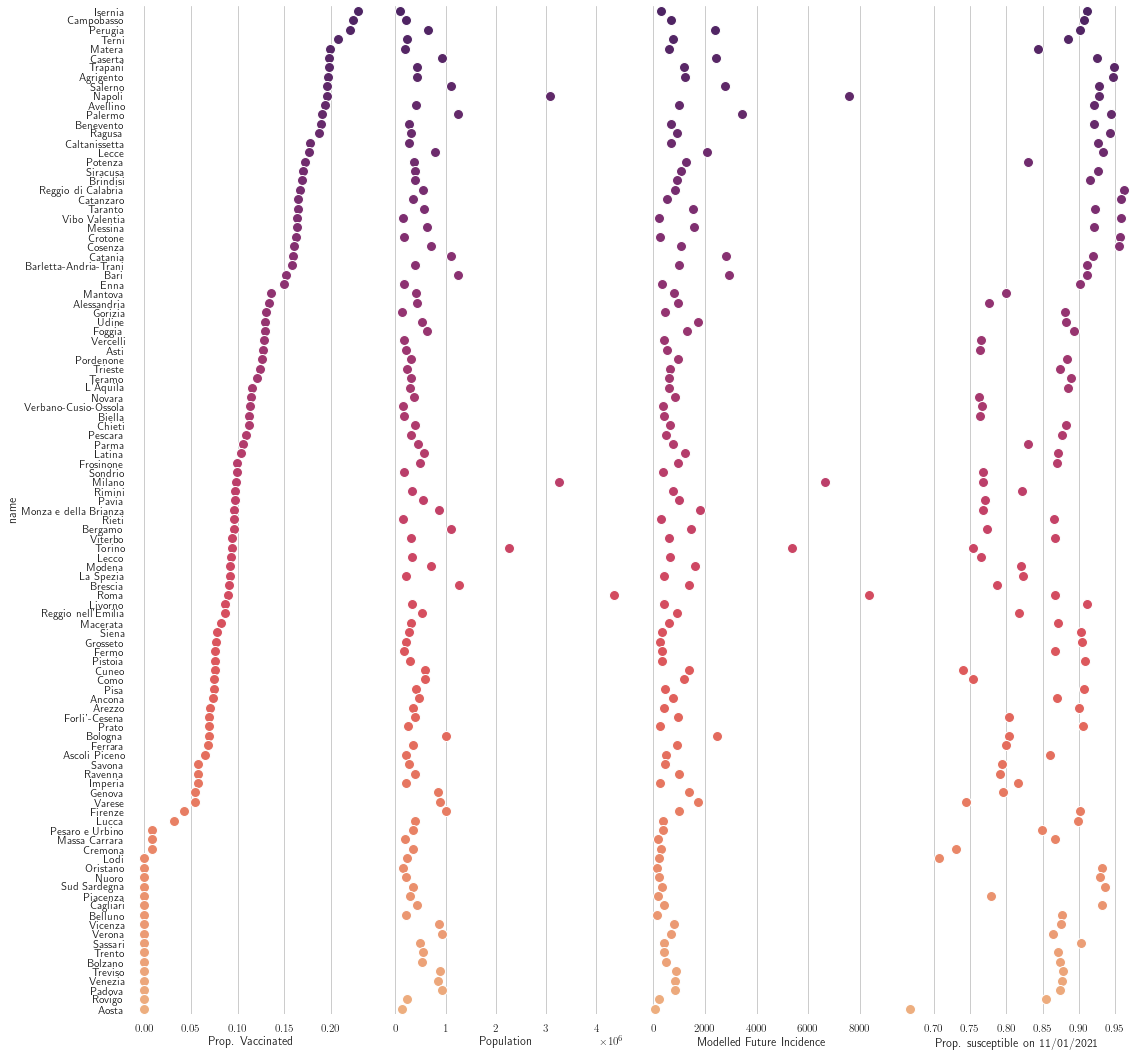

In [16]:
import seaborn as sns
sns.set_theme(style="whitegrid")
toplt = 'Pessimistic'
toplt = 'Optimistic'

df = results[toplt]['Optimal']

df = df.sort_values('total_vacc', ascending=False)
df = df[df.columns[13:]]
df['Vaccines Doses'] = df['total_vacc']
df['Prop. Vaccinated'] = df['total_vacc_pop']
df['Population'] = df['population']
df['Modelled Future Incidence'] = df['new_inf_bl']
df['Prop. susceptible on 11/01/2021'] = df['Sstart_pop']

#for col in df.columns[2:]:
#    df[col] = df[col]/df.population

# Make the PairGrid
g = sns.PairGrid(df.sort_values('Prop. Vaccinated', ascending=False),
                 x_vars=['Prop. Vaccinated', 'Population', 'Modelled Future Incidence', 'Prop. susceptible on 11/01/2021'], 
                 y_vars=["name"],
                 height=15, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
#titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
#          "Not distracted crashes", "No previous crashes"]

#for ax, title in zip(g.axes.flat, titles):#

#    # Set a different title for each axes
#    ax.set(title=title)

    # Make the grid horizontal instead of vertical
#    ax.xaxis.grid(False)
#    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.savefig(f'figures/SI_scatter_{toplt}.pdf')

In [30]:
# Choose how to prune mobility

nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 528
nnz before: 4088, after: 1148
nnz before: 4088, after: 5

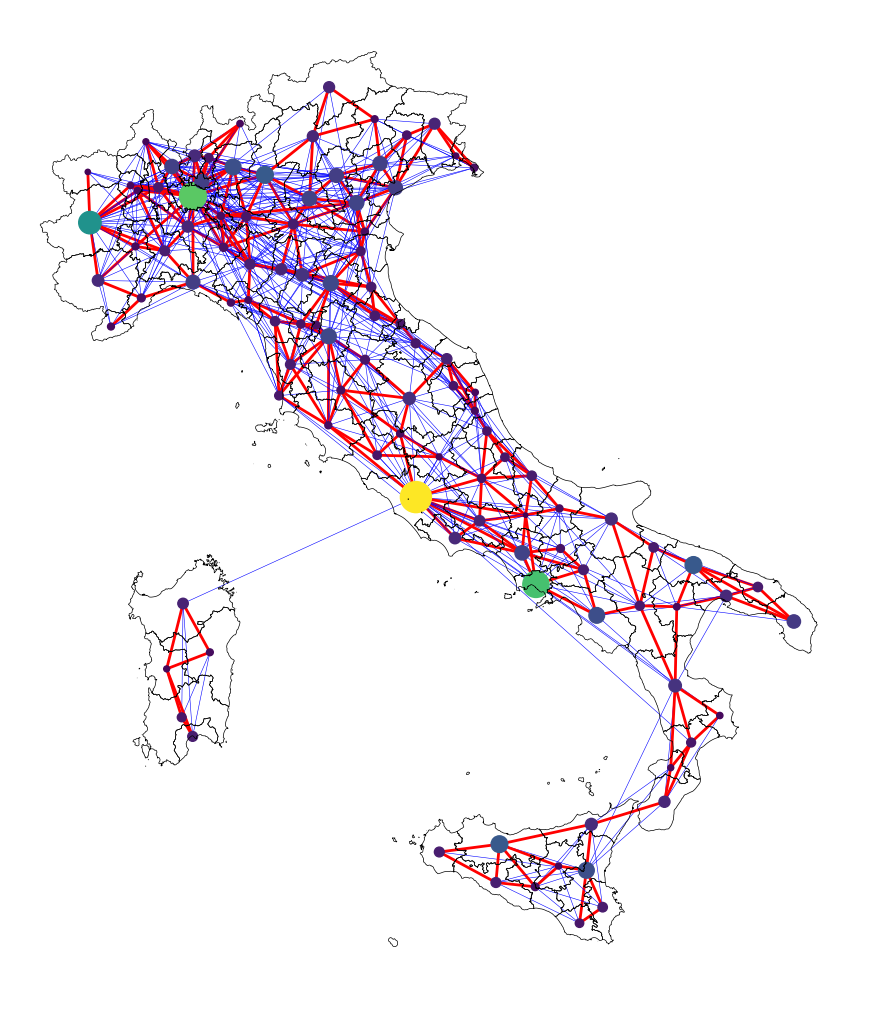

In [34]:
G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}

#p.prune_mobility(setup, mob_prun=0.00005)
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node[i]


    p.prune_mobility(setup, mob_prun=0.00005)
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=1, color = 'b')
    p.prune_mobility(setup, mob_prun=0.0006)
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=5, color='r')



fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi=100, constrained_layout=True) #

networkx.draw(G, 
          G.position, 
          node_size=500/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          node_color=[G.population[v] for v in G],
          width = 40* np.array([max(a['weight']/100,0.002) for u,v,a in G.edges(data=True)]),
         # edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
         edge_color= [a['color'] for u,v,a in G.edges(data=True)],
          edge_cmap = mpl.cm.viridis,
          cmap = mpl.cm.viridis,
          ax = ax,
         #with_labels=True
       )

#     # scale the axes equally
plt.xlim(min(setup.pos_node[:,0]) - 100000, max(setup.pos_node[:,0])+ 100000)
plt.ylim(min(setup.pos_node[:,1]) - 100000, max(setup.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="k", linewidth = .5)


#cmap = mpl.cm.viridis#sns.cm.rocket
#vmin = min([G.epi[v]['total_vacc']/G.population[v] for v in G])
#vmax = max([G.epi[v]['total_vacc']/G.population[v] for v in G])
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
##sm._A = []
#cmap = fig.colorbar(sm, ax=ax, shrink=.3,  ticks=np.arange(0, vmax, vmax/10),location = 'right')

#cmap.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(0, vmax,vmax/10)], fontsize=16)#, weight='bold')

plt.draw()